### imports

In [1]:
import pandas as pd
from pandas import DataFrame

import numpy as np

from collections import Counter

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem.Descriptors import qed
from rdkit import DataStructs

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import functools

import math

import itertools

#from PIL import Image
from IPython.display import Image, display

from mpl_toolkits.mplot3d import Axes3D

# functions
##### functions for data processing

In [2]:
def getpep(df, taglength, minALC, PELdesign):
    '''Takes a dataframe from peaks export, values for taglength and min ALC (int), dataframe with library design
    returns a dataframe with peptides filtered to match the library design and other contraints'''
    df = df[df['Tag length'] == taglength]
    df = df[df['ALC (%)'] > minALC]
    
    # specify replacement code for PTM to one letter 
    replacements = {'a':'A(+14.02)','b':'V(+12.00)','c':'P(+15.99)','d':'L(+1.98)','e':'L(+12.00)',
                    'f':'L(+28.03)','g':'F(+6.05)','h':'F(+60.02)','Kz':'K(+42.06)'}

    # modify strings in dic to allow escaping special characters
    for entry in replacements:
        temp = replacements[entry].translate(str.maketrans({"(":  r"\(",")":  r"\)","+": r"\+"}))
        replacements[entry] = temp

    # replace all PTM with the one letter code specified above
    for entry in replacements:
        df['Peptide']=df['Peptide'].str.replace(str(replacements[entry]), str(entry), regex=True)
        df['tag (>=0%)']=df['tag (>=0%)'].str.replace(str(replacements[entry]), str(entry), regex=True)
        
    
    # replace three letter code with one letter code
    one_letter_code = {'a':'Abu','b': 'Cpa','c': 'Hyp','d': 'Mox','e': 'Cba','f': 'Aoa','g': 'Cha',
                        'h': 'Dmf','A': 'Ala','F': 'Phe','K': 'Lys','L': 'Leu','P': 'Pro','S': 'Ser', 'T': 'Thr','V': 'Val','Y': 'Tyr', '':'none'}

    transposed_one_letter_code = {key: value for (value, key) in one_letter_code.items()}

    PELdesign = PELdesign.replace({'set_1': transposed_one_letter_code})
    PELdesign = PELdesign.replace({'set_2': transposed_one_letter_code})

    PELdesign['codon'] = PELdesign['set_1'] + PELdesign['set_2']

    #extract lists with possible codons
    linker_codons = PELdesign.loc[PELdesign['type'] == 'linker', 'codon'].values
    triBB_codons = PELdesign.loc[PELdesign['type'] == 'triBB', 'codon'].values
    CA_codons = PELdesign.loc[PELdesign['type'] == 'CA', 'codon'].values
    BA_codons = PELdesign.loc[PELdesign['type'] == 'BA', 'codon'].values

    #generate possible peptides
    pepset = ['A']
    pepset = [i+str(j) for i in pepset for j in BA_codons]      
    pepset = [i+'K' for i in pepset]
    pepset = [i+str(j) for i in pepset for j in CA_codons] 
    pepset = [i+'S' for i in pepset] 
    pepset = [i+str(j) for i in pepset for j in triBB_codons]
    pepset = [i+str(j) for i in pepset for j in linker_codons]
    pepset = [i+'Kz' for i in pepset]
    
#    pepset += ['AbPKeTSAFcKz','KgdVhPKTYLVz'] #add additional conjugates, i.e., controls 

    df = df[df['Peptide'].isin(pepset)]
    
    return df


def pepsum(sampledfs,cntrldfs):
    '''takes "dfs": a list of dataframes (sample and control)
    returns list of peptides that appear in every multiplicate of sample and none of the control'''
    
    maxscore = len(sampledfs)

    unique_sample = Counter(np.concatenate([x['Peptide'].unique() for x in sampledfs]))
    unique_sample_df = pd.DataFrame.from_dict(unique_sample, orient='index').rename(columns={'index':'Peptide', 0:'count_sample'})
    
    unique_cntrl = Counter(np.concatenate([x['Peptide'].unique() for x in cntrldfs]))
    unique_cntrl_df = pd.DataFrame.from_dict(unique_cntrl, orient='index').rename(columns={'index':'Peptide', 0:'count_cntrl'})

    res = pd.concat([unique_sample_df, unique_cntrl_df],axis = 1).fillna(0)
    res['dif'] = res["count_sample"] - res["count_cntrl"]

    resfiltered = res[res['dif'] == maxscore]
    
    while len(resfiltered) == 0:
        maxscore -= 1
        resfiltered = res[res['dif'] == maxscore]
        
    print(f'Found {len(resfiltered)} peptide sequences with the an enrichement score of {maxscore} out of {len(sampledfs)}.')
    
    return list(resfiltered.index.values), res


def binderqual(reslst,selections):
    '''Takes a list of encoded peptides (reslst) and a list of replicate dataframes (selections).
    Returns a list specifying the occurence and average ALC for each peptide.'''
    
    binderqual = dict.fromkeys(reslst)
    
    mzavg, rtavg = [], []
    
    for pep in reslst:
        pepscore = []
        mzpep, rtpep = [],[]
        for df in selections:
            seldf = df[df['Peptide'] == pep]
            ALClist = seldf['ALC (%)'].tolist()
            pepscore.extend(ALClist)
            mzpep.extend(seldf['m/z'].tolist())
            rtpep.extend(seldf['RT'].tolist())            
        binderqual[pep] = pepscore
        mzavg.append(round(sum(mzpep)/len(mzpep),4))
        rtavg.append(round(sum(rtpep)/len(rtpep),2))

    
    occurrences = []
    aALC = []
    for pep in binderqual:
        occurrences.append(len(binderqual[pep]))
        aALC.append(round(sum(binderqual[pep])/len(binderqual[pep]),1))
        
    dfbinderqual = pd.DataFrame(zip(reslst,occurrences,aALC,mzavg,rtavg), columns =['Peptides','occurrences','aALC','aMZ','aRT'])
    
    return dfbinderqual


def pepagg(df):
    '''Takes a processed df from peaks and aggregate important values.
    returns df with aggregated values.'''
    res = df.groupby(['Peptide'], as_index=True).agg({'Peptide':['count'],'ALC (%)':['mean'],
                                                      'm/z':['mean'],'RT':['mean','std']})
    res.columns = list(map('_'.join, res.columns.values))
    return res

def replicateagg(dfls):
    
    replicatesdfs = []
    
    for df in dfls:
        aggdf = pepagg(df)
        aggdf['replicate'] = 1
        replicatesdfs.append(aggdf)
        
    df = pd.concat(replicatesdfs)

    df = df.groupby(['Peptide']).agg({'Peptide_count':['sum'],'ALC (%)_mean':['mean'],'m/z_mean':['mean'],'RT_mean':['mean'],'RT_std':['mean'],'replicate':['sum']})
    df.columns = list(map('_'.join, df.columns.values))
    df = df.rename(columns={'ALC (%)_mean_mean': 'ALC', 'RT_mean_mean': 'RT','RT_std_mean': 'RT_std','m/z_mean_mean': 'm/z','Peptide_count_sum': 'count','replicate_sum': 'occurrence'})
    
    return df

##### functions for the decoder

In [3]:
def dencodingdict(PELdesign, BBtype):
    '''Takes a dataframe with the PELdesign and a string describing which building block type should be extracted
    returns a dictionary which decodes a peptide codon to the corresponding building block identifier'''
    return dict(zip(PELdesign[PELdesign['type'] == BBtype].codon, PELdesign[PELdesign['type'] == BBtype].assoc_no))


def structuredict(df, name):
    '''Takes df (dataframe) containing building blocks, and the name of the building block (string)
    returns a dict for converting building block identifiers into smiles for rxns'''
    
    identity = name + '_id'
    smiles = name + '_smiles'
    
    BBdf = df[[identity,smiles]].copy().dropna()
    BBdf[smiles] = BBdf[smiles].apply(lambda x: Chem.MolFromSmiles(x))
    BBdict = dict(zip(BBdf[identity], BBdf[smiles]))

    return BBdict


def bindervis(reslst):
    '''Takes list of strings of one letter peptide codes, returns the corresponding chemmol files.'''
    
    bb = [[res[1:3],res[4:6], res[7:9],res[9]] for res in reslst]
    
    dfencoded = pd.DataFrame(bb, columns = ['BA', 'CA','triBB','linker'])
    dfdecoded = dfencoded.replace({'BA': BA_encoding_dict, 'CA': CA_encoding_dict,
                                   'triBB': triBB_encoding_dict,'linker':linker_encoding_dict})
    dfmol = dfdecoded.replace({'BA': BAdict, 'CA': CAdict, 'triBB': triBBdict, 'linker':linkerdict})
    
    binders = []
    for index, row in dfmol.iterrows():
        binder = rxn1.RunReactants([row['triBB'], row['linker']])[0][0]
        binder = rxn2.RunReactants([binder, row['CA']])[0][0]
        binder = rxn3.RunReactants([binder, row['BA']])[0][0]
        binders.append(binder)

    binderQED = [QED.properties(x) for x in binders]
    
    legend = []
    for x, binder in enumerate(binderQED):
        binderQEDstring = (str(dfdecoded.iloc[x]['triBB']) + str(dfdecoded.iloc[x]['CA']).rjust(2, '0') 
                           + str(dfdecoded.iloc[x]['BA']).rjust(2, '0') 
                           +' (' + str(reslst[x]) + '): \n \n MW ' + str(round(binderQED[x][0]))
                           + '; logP ' + str(round(binderQED[x][1],1)) + '; HBA ' + str(round(binderQED[x][2]))
                           + '; HBD ' + str(round(binderQED[x][3])) + '; PSA ' + str(round(binderQED[x][4])))
        legend.append(binderQEDstring)
        
    plot = Draw.MolsToGridImage(binders, molsPerRow=3, maxMols = 200, legends = legend, 
                                subImgSize=(600,600), useSVG=False)
    
    display(plot)
    
    return binders

## define reactions for the buiding blocks ##
rxn1 = AllChem.ReactionFromSmarts("[Ni][*:1].[Ni][*:2]>>[*:1][*:2]")
rxn2 = AllChem.ReactionFromSmarts("[Co][*:1].[Co][*:2]>>[*:1][*:2]")
rxn3 = AllChem.ReactionFromSmarts("[Pd][*:1].[Pd][*:2]>>[*:1][*:2]")

# decoder

In [4]:
## read in general building block assignement ##

BBdf = pd.read_excel('library_design/library_building_blocks.xlsx')

triBBdict = structuredict(BBdf,'triBB')
linkerdict = structuredict(BBdf,'linker')
CAdict = structuredict(BBdf,'CA')
BAdict = structuredict(BBdf,'BA')
anilinedict = structuredict(BBdf,'aniline')

## read in libary specific encoding key ##

# replace three letter code with one letter code
one_letter_code = {'a':'Abu','b': 'Cpa','c': 'Hyp','d': 'Mox','e': 'Cba','f': 'Aoa','g': 'Cha',
                    'h': 'Dmf','A': 'Ala','F': 'Phe','K': 'Lys','L': 'Leu','P': 'Pro','S': 'Ser', 'T': 'Thr','V': 'Val','Y': 'Tyr', '':'none'}

transposed_one_letter_code = {key: value for (value, key) in one_letter_code.items()}

# library specific design
PELdesign = pd.read_excel('library_design/CC_PEL_design.xlsx',engine = 'openpyxl')

PELdesign = PELdesign.replace({'set_1': transposed_one_letter_code})
PELdesign = PELdesign.replace({'set_2': transposed_one_letter_code})

PELdesign['codon'] = PELdesign['set_1'] + PELdesign['set_2']

linker_encoding_dict = dencodingdict(PELdesign,'linker')
triBB_encoding_dict = dencodingdict(PELdesign,'triBB')
CA_encoding_dict = dencodingdict(PELdesign,'CA')
BA_encoding_dict = dencodingdict(PELdesign,'BA')

# peaks result processing

In [5]:
#specify parameters such as PELdesign and taglength
PELdesign = pd.read_excel('library_design/CC_PEL_design.xlsx', engine = 'openpyxl')
taglength = 11
minALC = 90

#read in peak exports (T=target protein, C=control protein)

T1 = getpep(pd.read_csv(r'CC_PEL_CAIX_1/all de novo candidates.csv'),taglength, minALC, PELdesign)
T2 = getpep(pd.read_csv(r'CC_PEL_CAIX_2/all de novo candidates.csv'),taglength, minALC, PELdesign)
T3 = getpep(pd.read_csv(r'CC_PEL_CAIX_3/all de novo candidates.csv'),taglength, minALC, PELdesign)

C1 = getpep(pd.read_csv(r'CC_PEL_strp_1/all de novo candidates.csv'),taglength, minALC, PELdesign)
C2 = getpep(pd.read_csv(r'CC_PEL_strp_2/all de novo candidates.csv'),taglength, minALC, PELdesign)
C3 = getpep(pd.read_csv(r'CC_PEL_strp_3/all de novo candidates.csv'),taglength, minALC, PELdesign)

In [6]:
reslst1, resdf = pepsum([T1,T2,T3],[C1,C2,C3])

Found 219 peptide sequences with the an enrichement score of 3 out of 3.


In [7]:
sample = replicateagg([T1,T2,T3])
control = replicateagg([C1,C2,C3])

compjoin = sample.join(control, how='outer',lsuffix='_sample', rsuffix='_cntrl')
compjoin = compjoin.fillna(0).query('ALC_sample >= 90')

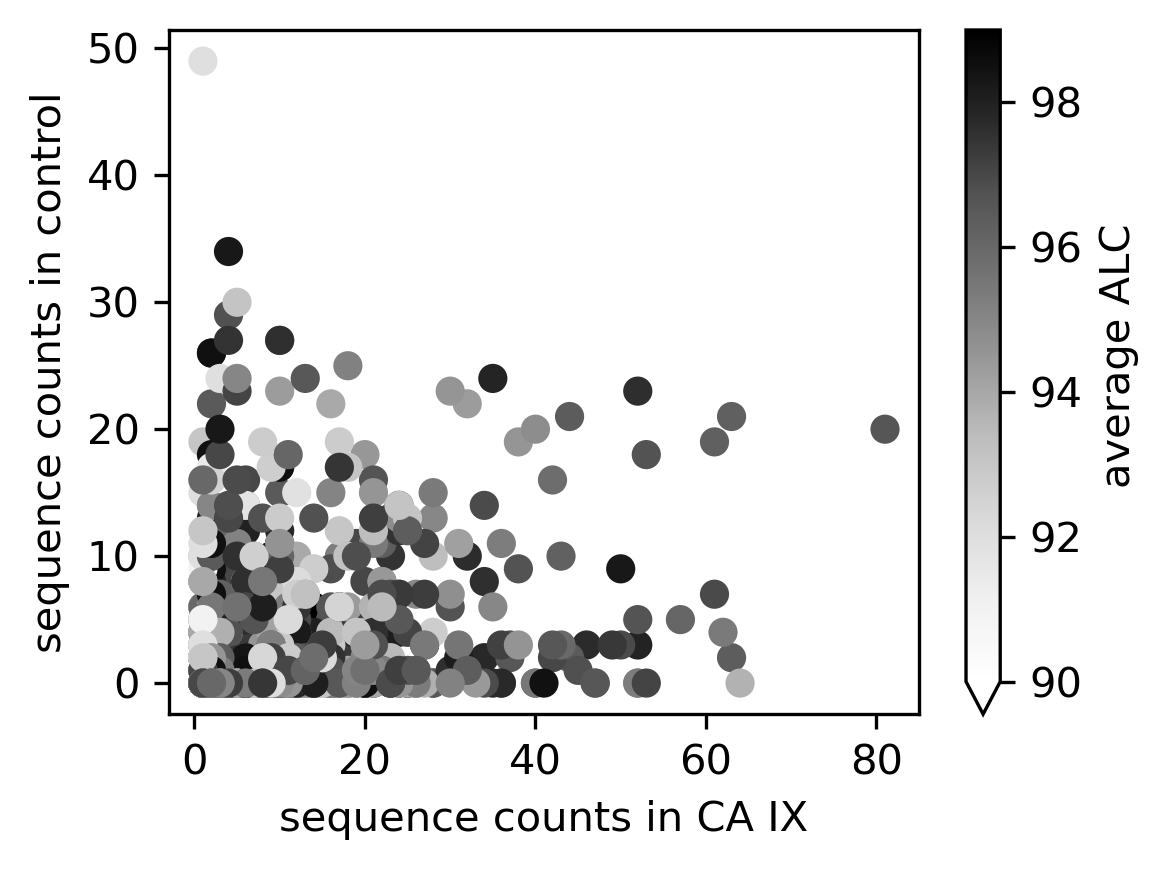

In [8]:
x = compjoin['count_sample']
y = compjoin['count_cntrl']

figure(figsize=(4, 3), dpi=300)
plt.scatter(x, y, c=compjoin['ALC_sample'], cmap='Greys')
#sns.scatterplot(data=compjoinsub, x="count_sample", y="count_cntrl", color="red")
#axline([0, 0], [1, 1], ls = '-', color='black',linewidth=1)
plt.xlabel("sequence counts in CA IX")
plt.ylabel("sequence counts in control")

cbar = plt.colorbar(orientation = 'vertical',extend='min')
cbar.set_label(label='average ALC')
plt.clim(90,99)

#plt.xlim(xmax= 110)
#plt.ylim(ymax= 110)

plt.tight_layout()
#plt.savefig('enrichement_plot_CC_PEL_target_protein.pdf')

In [9]:
#query stringency according to selection results

df = compjoin.query('count_sample > 38 & count_cntrl < 1 & ALC_sample >= 94 & RT_std_sample <0.3')
df = df.sort_values(by='count_sample', ascending = False)
df

,count_sample,ALC_sample,m/z_sample,RT_sample,RT_std_sample,occurrence_sample,count_cntrl,ALC_cntrl,m/z_cntrl,RT_cntrl,RT_std_cntrl,occurrence_cntrl
Peptide,,,,,,,,,,,,
AVeKVgSYTAKz,52.0,95.619674,429.610760,46.751009,0.135458,3.0,0.0,0.0,0.0,0.0,0.0,0.0
AVeKVgSYdAKz,52.0,95.295116,434.282397,52.475513,0.149419,3.0,0.0,0.0,0.0,0.0,0.0,0.0
AVeKTgSFaAKz,47.0,96.430833,419.607257,48.790581,0.114146,3.0,0.0,0.0,0.0,0.0,0.0,0.0
AVeKcgShSAKz,47.0,96.570833,444.273879,42.116708,0.102059,3.0,0.0,0.0,0.0,0.0,0.0,0.0
AdeKAhShTAKz,41.0,98.454212,458.265321,37.507271,0.100772,3.0,0.0,0.0,0.0,0.0,0.0,0.0
AVeKTgSFdAKz,40.0,96.113122,429.610676,48.596750,0.110471,3.0,0.0,0.0,0.0,0.0,0.0,0.0
AVeKcgSFaAKz,40.0,95.506944,423.607277,44.956597,0.129386,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#compjoin[compjoin.index == 'AbPKeTSAFcKz'] #check for additionl control peptides if applicable

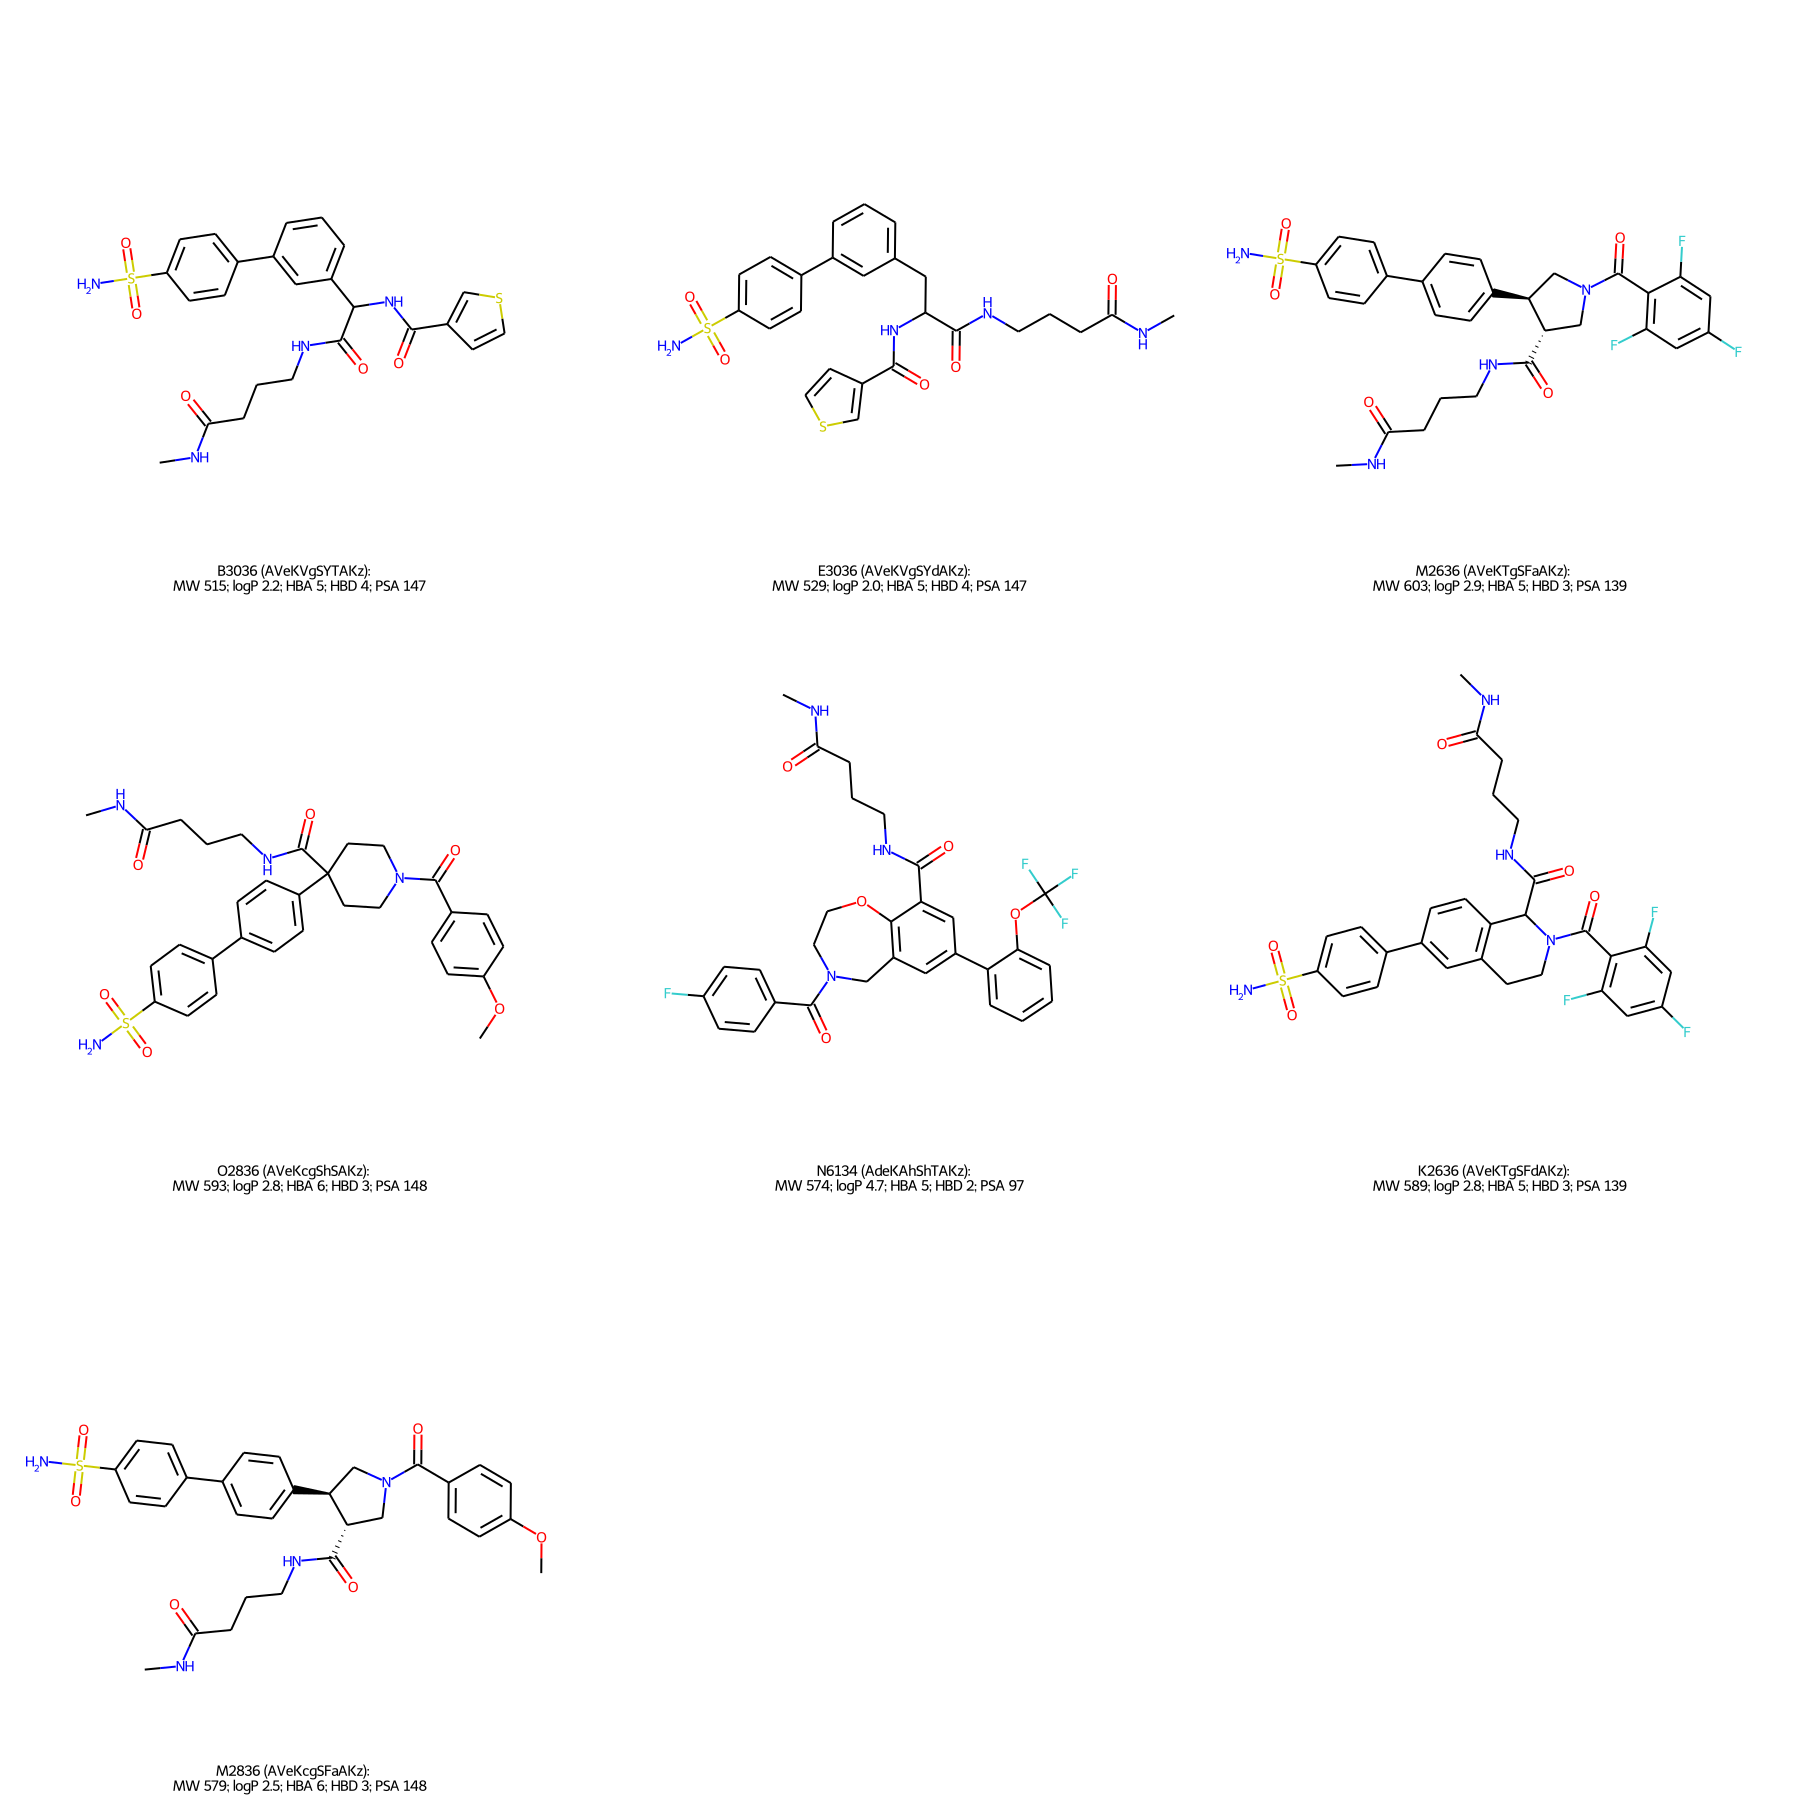

In [11]:
peps = df.index.values.tolist()
#peps.remove('AbPKeTSAFcKz')
binders = bindervis(peps)

In [12]:
#check for specific occurrences
T2[T2['Peptide'] == 'AVeKVgSYTAKz']

,Fraction,Scan,Source File,Peptide,Tag length,ALC (%),Length,m/z,z,RT,Mass,ppm,local confidence (%),tag (>=0%),mode
79924,121,13401,283-155_C2.raw,AVeKVgSYTAKz,11,97,11,429.6107,3,46.53,1285.812,-1.4,94 97 97 97 98 99 99 99 94 97 99,AVeKVgSYTAKz,HCD
80058,121,13418,283-155_C2.raw,AVeKVgSYTAKz,11,99,11,429.6110,3,46.57,1285.812,-0.7,93 97 100 100 100 100 100 100 99 100 100,AVeKVgSYTAKz,ETHCD/HCD
80059,121,13418,283-155_C2.raw,AVeKVgSYTAKz,11,92,11,429.6110,3,46.57,1285.812,-0.7,78 80 92 97 95 96 98 94 93 98 98,AVeKVgSYTAKz,ETHCD
80069,121,13419,283-155_C2.raw,AVeKVgSYTAKz,11,97,11,429.6110,3,46.58,1285.812,-0.7,93 97 99 99 99 99 99 98 92 95 99,AVeKVgSYTAKz,HCD
80213,121,13438,283-155_C2.raw,AVeKVgSYTAKz,11,92,11,429.6110,3,46.62,1285.812,-0.6,82 84 96 98 88 87 94 96 94 98 99,AVeKVgSYTAKz,ETHCD
80352,121,13457,283-155_C2.raw,AVeKVgSYTAKz,11,93,11,429.6108,3,46.67,1285.812,-1.1,83 84 94 98 96 96 98 93 93 98 99,AVeKVgSYTAKz,ETHCD
80536,121,13479,283-155_C2.raw,AVeKVgSYTAKz,11,98,11,429.6110,3,46.72,1285.812,-0.7,92 97 100 100 100 100 100 100 100 100 100,AVeKVgSYTAKz,ETHCD/HCD
80537,121,13479,283-155_C2.raw,AVeKVgSYTAKz,11,94,11,429.6110,3,46.72,1285.812,-0.7,84 85 97 98 94 92 95 98 98 99 100,AVeKVgSYTAKz,ETHCD
80547,121,13480,283-155_C2.raw,AVeKVgSYTAKz,11,97,11,429.6110,3,46.72,1285.812,-0.7,92 97 99 99 99 99 99 99 94 96 99,AVeKVgSYTAKz,HCD
80722,121,13500,283-155_C2.raw,AVeKVgSYTAKz,11,94,11,429.6108,3,46.77,1285.812,-1.2,82 83 97 99 97 96 96 97 97 99 99,AVeKVgSYTAKz,ETHCD


In [13]:
#generate smiles of binders to transfer into chemdraw
bindersmiles = [Chem.MolToSmiles(x) for x in binders]
bindersmiles

['CNC(=O)CCCNC(=O)C(NC(=O)c1ccsc1)c1cccc(-c2ccc(S(N)(=O)=O)cc2)c1',
 'CNC(=O)CCCNC(=O)C(Cc1cccc(-c2ccc(S(N)(=O)=O)cc2)c1)NC(=O)c1ccsc1',
 'CNC(=O)CCCNC(=O)[C@H]1CN(C(=O)c2c(F)cc(F)cc2F)C[C@@H]1c1ccc(-c2ccc(S(N)(=O)=O)cc2)cc1',
 'CNC(=O)CCCNC(=O)C1(c2ccc(-c3ccc(S(N)(=O)=O)cc3)cc2)CCN(C(=O)c2ccc(OC)cc2)CC1',
 'CNC(=O)CCCNC(=O)c1cc(-c2ccccc2OC(F)(F)F)cc2c1OCCN(C(=O)c1ccc(F)cc1)C2',
 'CNC(=O)CCCNC(=O)C1c2ccc(-c3ccc(S(N)(=O)=O)cc3)cc2CCN1C(=O)c1c(F)cc(F)cc1F',
 'CNC(=O)CCCNC(=O)[C@H]1CN(C(=O)c2ccc(OC)cc2)C[C@@H]1c1ccc(-c2ccc(S(N)(=O)=O)cc2)cc1']